# Fake News Project
Ulrik Bjørn Meelby | rgt545@alumni.ku.dk 

## Part 1: Data Processing

### Task 1

In [3]:
import pandas as pd
from cleantext import clean
import re
import matplotlib.pyplot as plt 
import nltk
# download if package is missing 
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# Retrieve the data from URL as a pandas DataFrame.
url = "https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv"
df = pd.read_csv(url,index_col=0)
print(df.shape)

(250, 15)


In [5]:
# Cleaning 

def clean_text(s):
    s = clean(s, 
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_number="<NUM>",
    lang="en")                       # set to 'de' for German special handling
    
    pattern = r"\b(january|february|march|april|may|june|july|august|september|october|november|december)[ ]?<num>,*[ ]?<num>"
    s = re.sub(pattern,"<date>",s)
    s = re.sub("<num><num>","<num>",s) # bible verse reference fix
    
    return s


In [6]:
# Clean the data sample using the automatic cleaning method
df_cleaned = df.copy()
df_cleaned['content'] = df['content'].apply(clean_text)

In [7]:
# Processing

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import itertools

def compute_vocabulary_size(s):
    return len(set(s))

# Tokenization
from nltk.tokenize import TreebankWordTokenizer
tknzr = TreebankWordTokenizer()
tknzr.PARENS_BRACKETS = (re.compile('[\\]\\[\\(\\)\\{\\}]'), ' \\g<0> ')
tokens = [tknzr.tokenize(i) for i in df_cleaned['content']]

# Removal of stop words
vocab = list(itertools.chain(*tokens)) # flatten list of lists into one big list
stop_words = set(stopwords.words('english'))  
vocab_no_stopwords = tuple(filter(lambda s: s not in stop_words, vocab))
vocab_size = compute_vocabulary_size(vocab)
vocab_no_stopwords_size = compute_vocabulary_size(vocab_no_stopwords)

print(">>> Removal of stop words")
print("The size of the vocabulary including stopwords is {}.".format(vocab_size))
print("The size of the vocabulary excluding stopwords {}.".format(vocab_no_stopwords_size))

reductiont_rate = (vocab_size-vocab_no_stopwords_size)/vocab_size*100

print("The reduction rate is {:.2f}%".format(reductiont_rate))

max_reductiont_rate = len(stop_words)/vocab_size*100
print("The maximum possible reduction rate is {:.2f}% given the size of the dataset.".format(max_reductiont_rate))

# Stemming
from nltk.stem import PorterStemmer

ps = PorterStemmer()
vocab_post_stemming = list(map(ps.stem, vocab_no_stopwords))
vocab_post_stemming_size = compute_vocabulary_size(vocab_post_stemming)

print(">>> Stemming")
print("The size of the vocabulary excluding stopwords {}.".format(vocab_no_stopwords_size))
print("The size of the vocabulary post stemming {}.".format(vocab_post_stemming_size))

reductiont_rate = (vocab_no_stopwords_size-vocab_post_stemming_size)/vocab_no_stopwords_size*100

print("The reduction rate is {:.2f}%".format(reductiont_rate))

>>> Removal of stop words
The size of the vocabulary including stopwords is 16680.
The size of the vocabulary excluding stopwords 16548.
The reduction rate is 0.79%
The maximum possible reduction rate is 1.07% given the size of the dataset.
>>> Stemming
The size of the vocabulary excluding stopwords 16548.
The size of the vocabulary post stemming 11131.
The reduction rate is 32.74%


### Task 2

In [8]:
df = df_cleaned 

from functools import wraps
import time

def timeit(func):
    """Decorator function that measures execution time"""
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

@timeit
def explore_processed():
    """Compute various data exploration metrics working on the processed data"""
    return {"urls":vocab_post_stemming.count("<url>"),
          "dates":vocab_post_stemming.count("<date>"),
          "num":vocab_post_stemming.count("<num>")} 

@timeit    
def explore_dataframe():  
    """Compute various data exploration metrics working on the cleaned DataFrame"""
    res = {"urls":0,
          "dates":0,
          "num":0}
    
    for i in df['content']:
        for w in i.split():
            #print(w)
            if w == "<url>":
                res["urls"]+=1
            if w == "<date>":
                res["dates"]+=1
            if w == "<num>":
                res["num"]+=1                         
    return res

print(explore_processed())
print(explore_dataframe())

Function explore_processed() {} Took 0.0095 seconds
{'urls': 240, 'dates': 76, 'num': 1897}
Function explore_dataframe() {} Took 0.0335 seconds
{'urls': 240, 'dates': 76, 'num': 1731}


In [9]:
import collections

# Most frequently appearing words
N = 100
topN = {  "raw":collections.Counter(vocab).most_common(N),
            "no_stopwords":collections.Counter(vocab_no_stopwords).most_common(N),
            "post_stemming":collections.Counter(vocab_post_stemming).most_common(N)}

raw = list(zip(*topN["raw"]))[0]
no_stopwords = list(zip(*topN["no_stopwords"]))[0]
post_stemming = list(zip(*topN["post_stemming"]))[0]

# Code for pretty Latex table
for i in range(len(topN["raw"])):
    print("{}&{}&{}&{}\\\\ \hline".format(i+1,raw[i],no_stopwords[i],post_stemming[i]))

1&the&<num>&<num>\\ \hline
2&of&us&one\\ \hline
3&to&one&us\\ \hline
4&and&people&like\\ \hline
5&a&like&time\\ \hline
6&in&would&peopl\\ \hline
7&is&trump&state\\ \hline
8&that&time&trump\\ \hline
9&<num>&also&use\\ \hline
10&for&new&would\\ \hline
11&it&blockchain&market\\ \hline
12&are&<url>&year\\ \hline
13&on&said&also\\ \hline
14&with&many&new\\ \hline
15&this&market&blockchain\\ \hline
16&you&next&make\\ \hline
17&as&even&<url>\\ \hline
18&be&could&think\\ \hline
19&i&think&thing\\ \hline
20&by&way&said\\ \hline
21&have&government&go\\ \hline
22&not&state&way\\ \hline
23&was&two&mani\\ \hline
24&from&see&report\\ \hline
25&at&first&govern\\ \hline
26&or&$&even\\ \hline
27&we&president&nation\\ \hline
28&they&life&take\\ \hline
29&its&may&next\\ \hline
30&but&make&get\\ \hline
31&your&world&see\\ \hline
32&has&things&presid\\ \hline
33&an&take&could\\ \hline
34&their&get&work\\ \hline
35&can&years&say\\ \hline
36&all&bitcoin&stock\\ \hline
37&will&states&american\\ \hline
38&more

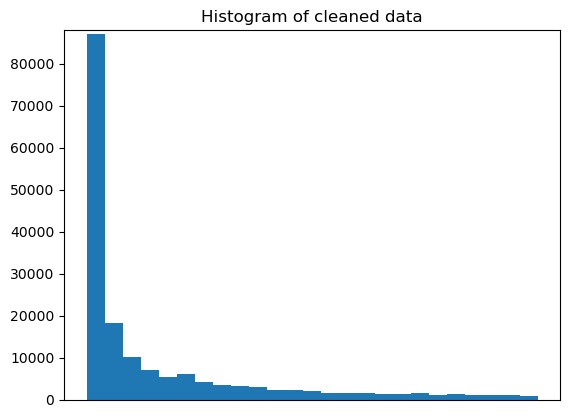

In [10]:
d = vocab
plt.hist(pd.Series(d),histtype="stepfilled",bins=25)
plt.xticks([])
plt.title("Histogram of cleaned data")
plt.ylim(top=88000) 
plt.show()

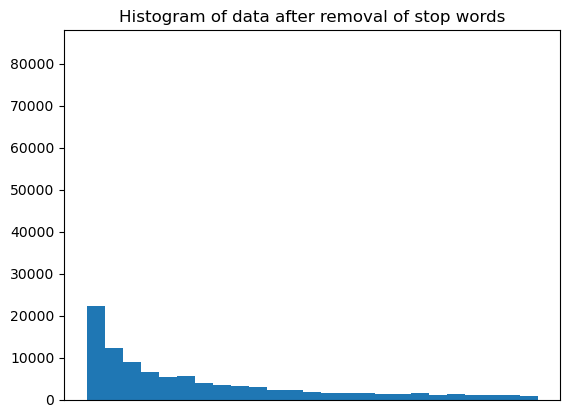

In [11]:
d = vocab_no_stopwords
plt.hist(pd.Series(d),histtype="stepfilled",bins=25)
plt.xticks([])
plt.title("Histogram of data after removal of stop words")
plt.ylim(top=88000)
plt.show()

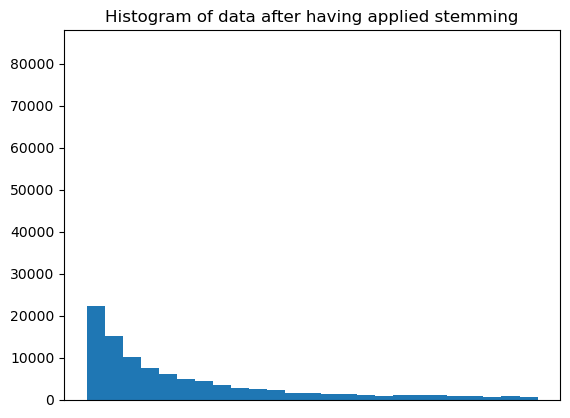

In [12]:
d = vocab_post_stemming
plt.hist(pd.Series(d),histtype="stepfilled",bins=25)
plt.title("Histogram of data after having applied stemming")
plt.xticks([])
plt.ylim(top=88000)
plt.show()

### Task 3

In [13]:
import os
from nltk.tokenize import TreebankWordTokenizer

RUN_PIPELINE = False

if RUN_PIPELINE:
    tknzr = TreebankWordTokenizer()
    ps = PorterStemmer()
    tknzr.PARENS_BRACKETS = (re.compile('[\\]\\[\\(\\)\\{\\}]'), ' \\g<0> ')

    # Retrieve the data from URL as a pandas DataFrame.
    path = "/kaggle/input/fake-news/huge_dataset.csv"
    txtfilereader = pd.read_csv(path,index_col=0,on_bad_lines="warn",chunksize=5000)

    # make header
    df_chunk = txtfilereader.get_chunk(0)
    df_chunk.to_csv('data.csv', mode="w", index=False, header=True)

    # specify size of file in megabytes
    FILE_SIZE_GOAL = 3000


    def apply_pipeline(df):
        """Apply preprocessing pipeline to dataframe"""

        def process(s):
            """Apply stop word removal and stemming to a single data point"""
            tokens = tknzr.tokenize(s)
            s = tuple(filter(lambda s: s not in stop_words, tokens))
            return " ".join(list(map(ps.stem, s)))


        df['content'] = df['content'].apply(clean_text).apply(process)
        return df

    file_size_current = os.stat('data.csv').st_size/10**6


    while (file_size_current < FILE_SIZE_GOAL):
        try: 
            print("{:.2f} megabytes has been processed.".format(file_size_current))
            df_chunk = apply_pipeline(txtfilereader.get_chunk())
            df_chunk.to_csv('data.csv', mode='a', index=False, header=False)
            file_size_current = os.stat('data.csv').st_size/10**6
        except Exception as e:
            print(f'caught {type(e)}: e')



### Task 4

In [14]:
# Retrieve the data from URL as a pandas DataFrame.
df = pd.read_csv("data2.csv",index_col=0,low_memory=False)
print(df.shape)

(1505000, 15)


In [15]:
from sklearn.utils import shuffle

def split(df,training_split,validation_split,test_split):
    """Uniformly split Dataframe into training, validation, and test set specified
    by the split percentages given as arguments. The resulting data sets are
    saved to files."""
    df = shuffle(df)
    n_rows = df.shape[0]
    idx1, idx2 = int(training_split*n_rows/100), int((training_split+validation_split)*n_rows/100)
    
    training,validation,test = df.iloc[:idx1,:],df.iloc[idx1:idx2,:],df.iloc[idx2:,:]
    
    training.to_csv('training.csv', mode="w", index=False, header=True)
    validation.to_csv('validation.csv', mode="w", index=False, header=True)
    test.to_csv('test.csv', mode="w", index=False, header=True)

    return (training, validation, test)
    
training, validation, test = split(df,80,10,10)
    


## Part 2

### Task 1

In [16]:
import re

training_sample = training.iloc[:,:]
ps = PorterStemmer()
from sklearn.metrics import accuracy_score


tknzr = TreebankWordTokenizer()
tknzr.PARENS_BRACKETS = (re.compile('[\\]\\[\\(\\)\\{\\}]'), ' \\g<0> ')

fake_words = set([ps.stem(w) for w in ["trump","hoax","establishment","jewish"
                                       "aliens","qanon","freedom","lie","liar",
                                      "propaganda","truth","woke","socialism",
                                      "speech","gun","conspiracy","coincidence"]])

def words_in_content(content):
    content = str(content)
    if set(content.split()).intersection(fake_words):
        return "fake"
    else:
        return "reliable"
    
def group_labels(label):
    if label != "reliable":
        return "fake"
    else:
        return "reliable"

y_pred = training_sample['content'].apply(words_in_content)
y_true = training_sample['type'].apply(group_labels)
res = accuracy_score(y_true, y_pred)
print("The accuracy of the baseline model is {:.2f}%".format(res*100))

The accuracy of the baseline model is 34.80%


### Task 2

In [17]:
# Baseline model using the mode of the distribution

y_pred = training_sample['content'].apply(lambda x:"fake")
res = accuracy_score(y_true, y_pred)
print("The accuracy of the baseline model is {:.2f}%".format(res*100))


The accuracy of the baseline model is 99.55%


In [18]:
from random import random
# Grouping revisited
def group_labels_revised(label):
    if label in ["political", "unknown","clickbait","satire","rumor"]:
        if random()>0.5:
            return "reliable"
        else:
            return "fake"
    elif label == "reliable":
        return "reliable"
    else:
        return "fake"

y_pred = training_sample['content'].apply(words_in_content)
y_true = training_sample['type'].apply(group_labels_revised)
res = accuracy_score(y_true, y_pred)
print("The accuracy of the baseline model is {:.2f}%".format(res*100))

y_pred = training_sample['content'].apply(lambda x:"fake")
y_true = training_sample['type'].apply(group_labels_revised)
res = accuracy_score(y_true, y_pred)
print("The accuracy of the baseline model is {:.2f}%".format(res*100))

The accuracy of the baseline model is 40.88%
The accuracy of the baseline model is 79.96%


## Part 3

In [21]:
# Loading and encoding of the training data

import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

training = pd.concat([validation,training])
enc = LabelEncoder()
X_train = training['content'].apply(lambda x : str(x))
Y_train = enc.fit_transform(training['type'].apply(group_labels_revised))

In [22]:
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

try:
    TrainX_Tfidf = pickle.load(open("TrainX_Tfidf", "rb"))
    Tfidf_vect = pickle.load(open("Tfidf_vect", "rb"))
except:
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(vocab_post_stemming)
    TrainX_Tfidf = Tfidf_vect.transform(X_train)
    pickle.dump(TrainX_Tfidf, open("TrainX_Tfidf", 'wb'))
    pickle.dump(Tfidf_vect, open("Tfidf_vect", 'wb'))

In [25]:
N = 10000
# A more reasonable running time
svc = SVC(kernel='linear',C=100,gamma=0.1)
svc.fit(TrainX_Tfidf[:N,:],Y_train[:N])

filename = 'tiny_model3.sav'
pickle.dump(svc, open(filename, 'wb'))
print("tiny_model saved")

tiny_model saved


In [ ]:
N = 100000
# A more reasonable running time
svc = SVC(kernel='rbf',C=1.0,gamma='scale',random_state=42)
svc.fit(TrainX_Tfidf[:N,:],Y_train[:N])

#print(svc.score(TrainX_Tfidf,Y_train))

filename = 'tiny_model2.sav'
pickle.dump(svc, open(filename, 'wb'))
print("tiny_model2 saved")

In [ ]:
import pickle 

# Train SVM
N = 1000000
# A more reasonable running time
svc = SVC(kernel='linear')
svc.fit(TrainX_Tfidf[:N,:],Y_train[:N])

#print(svc.score(TrainX_Tfidf,Y_train))

filename = 'small_model.sav'
pickle.dump(svc, open(filename, 'wb'))
print("small_model saved")

In [ ]:
import pickle 

# Train SVM

# A more reasonable running time
svc = SVC(kernel='linear')
svc.fit(TrainX_Tfidf,Y_train)

svc.score(TrainX_Tfidf,Y_train)


filename = 'finalized_model.sav'
pickle.dump(svc, open(filename, 'wb'))

In [ ]:
# Train SVM


# Takes impossibly long time to run
svc = SVC(kernel='rbf')
param_grid = {'C': np.logspace(-3,3,num=7), 'gamma': np.logspace(-5,1,num=7)}
clf = GridSearchCV(svc,param_grid,cv=5)
clf.fit(TrainX_Tfidf,Y_train)

clf.score(TrainX_Tfidf,Y_train)

a = clf.best_params_
print("Hyperparameters chosen C = {} and gamma = {}".format(a["C"],a["gamma"]))

filename = 'finalized_model2.sav'
pickle.dump(clf, open(filename, 'wb'))

## Part 4

### Task 1

In [26]:
import pickle
filename = "tiny_model3.sav"
model = pickle.load(open(filename, "rb"))
enc = LabelEncoder()
X_test = test['content'].apply(lambda x : str(x))
Y_test = enc.fit_transform(test['type'].apply(group_labels_revised))
TestX_Tfidf = Tfidf_vect.transform(X_test)
Y_test_pred = model.predict(TestX_Tfidf)

In [62]:
from sklearn.metrics import f1_score
print("The advanced model score on test set: {:.2f}".format(f1_score(Y_test,Y_test_pred)))
K = Y_test.shape[0]
Y_test_pred_base1 = np.zeros(K)
arr = np.zeros(K//2)
arr2 = np.ones(K//2)
Y_test_pred_base2 = np.append(arr,arr2)
print("Baseline #1 score on test set: {:.2f}".format(f1_score(Y_test,Y_test_pred_base1)))
print("Baseline #2 score on test set: {:.2f}".format(f1_score(Y_test,Y_test_pred_base2)))


The advanced model score on test set: 0.23
Baseline #1 score on test set: 0.00
Baseline #2 score on test set: 0.29
